In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [36]:
# Load the dataset
file_path = 'Banglore_traffic_Dataset.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows to understand the structure of the data
print(dataset.head())


         Date    Area Name Road/Intersection Name  Traffic Volume  \
0  2022-01-01  Indiranagar          100 Feet Road           50590   
1  2022-01-01  Indiranagar               CMH Road           30825   
2  2022-01-01   Whitefield    Marathahalli Bridge            7399   
3  2022-01-01  Koramangala    Sony World Junction           60874   
4  2022-01-01  Koramangala          Sarjapur Road           57292   

   Average Speed  Travel Time Index  Congestion Level  \
0      50.230299           1.500000        100.000000   
1      29.377125           1.500000        100.000000   
2      54.474398           1.039069         28.347994   
3      43.817610           1.500000        100.000000   
4      41.116763           1.500000        100.000000   

   Road Capacity Utilization  Incident Reports  Environmental Impact  \
0                 100.000000                 0               151.180   
1                 100.000000                 1               111.650   
2                  36.3965

In [37]:
print(dataset.dtypes)


Date                                   object
Area Name                              object
Road/Intersection Name                 object
Traffic Volume                          int64
Average Speed                         float64
Travel Time Index                     float64
Congestion Level                      float64
Road Capacity Utilization             float64
Incident Reports                        int64
Environmental Impact                  float64
Public Transport Usage                float64
Traffic Signal Compliance             float64
Parking Usage                         float64
Pedestrian and Cyclist Count            int64
Weather Conditions                     object
Roadwork and Construction Activity     object
dtype: object


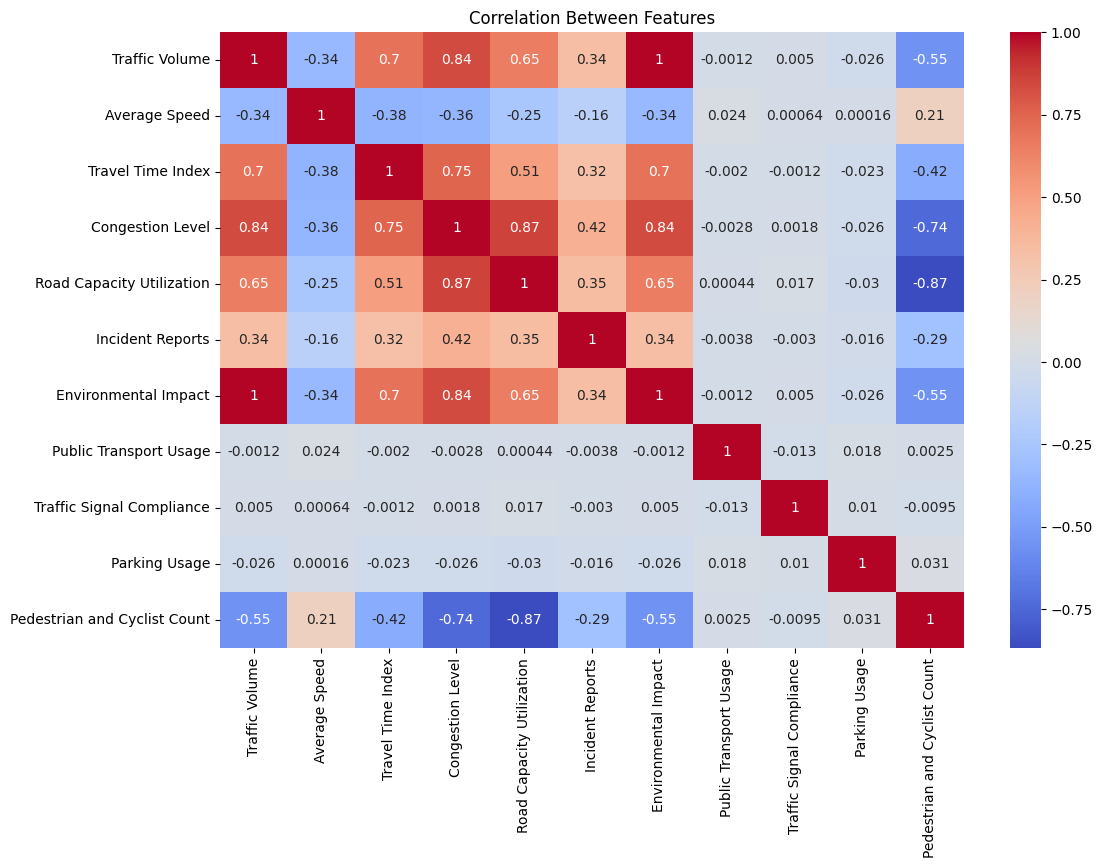

In [38]:
# Drop non-numeric columns
numeric_dataset = dataset.drop(columns=['Date', 'Area Name', 'Road/Intersection Name', 'Weather Conditions', 'Roadwork and Construction Activity'])

# Now, plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_dataset.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features')
plt.show()


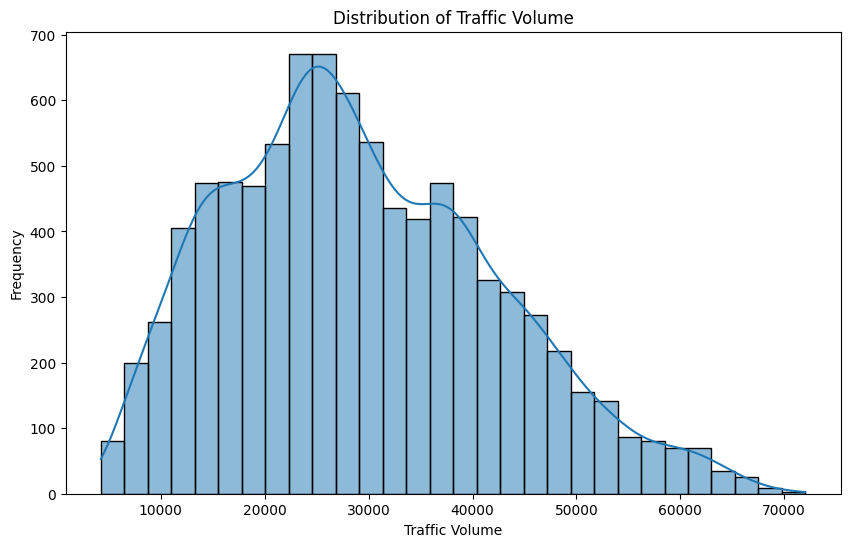

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of Traffic Volume
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Traffic Volume'], bins=30, kde=True)
plt.title('Distribution of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()




In [40]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Convert the Date column to datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Extract day, month, and year from the Date column
dataset['Day'] = dataset['Date'].dt.day
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year

# Drop the original Date column
dataset = dataset.drop('Date', axis=1)

# Encoding categorical columns
categorical_columns = ['Area Name', 'Road/Intersection Name', 'Weather Conditions', 'Roadwork and Construction Activity']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])
    label_encoders[col] = le

# Scaling the numerical features
scaler = MinMaxScaler()
numerical_columns = dataset.columns.difference(categorical_columns)
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

# Display the first few rows after preprocessing
print(dataset.head())


   Area Name  Road/Intersection Name  Traffic Volume  Average Speed  \
0          2                       0        0.683671       0.433156   
1          2                       3        0.392178       0.134360   
2          6                       8        0.046692       0.493967   
3          4                      11        0.835339       0.341271   
4          4                       9        0.782512       0.302572   

   Travel Time Index  Congestion Level  Road Capacity Utilization  \
0           1.000000          1.000000                   1.000000   
1           1.000000          1.000000                   1.000000   
2           0.078067          0.244494                   0.217287   
3           1.000000          1.000000                   1.000000   
4           1.000000          1.000000                   1.000000   

   Incident Reports  Environmental Impact  Public Transport Usage  \
0               0.0              0.683671                0.866414   
1               0.1 

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define the sequence length (number of time steps)
sequence_length = 10

# Create sequences and labels
X, y = [], []
for i in range(len(dataset) - sequence_length):
    X.append(dataset.iloc[i:i + sequence_length].values)
    y.append(dataset.iloc[i + sequence_length]['Traffic Volume'])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape X to be suitable for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], sequence_length, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, X_test.shape[2]))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (6248, 10, 18)
X_test shape: (2678, 10, 18)
y_train shape: (6248,)
y_test shape: (2678,)


In [46]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical strings or integers if needed
y_train = np.array(y_train).astype(str)
y_test = np.array(y_test).astype(str)

# Combine train and test labels
combined_labels = np.concatenate([y_train, y_test])

# Initialize and fit LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit(combined_labels)

# Transform labels
y_train_encoded = label_binarizer.transform(y_train)
y_test_encoded = label_binarizer.transform(y_test)

# Convert to one-hot encoding if necessary
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [50]:
import numpy as np

# Check the data types
print(X_train.dtype)
print(X_test.dtype)
print(y_train.dtype)
print(y_test.dtype)

# Convert to numeric type if needed
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Check the shape of your data
print(X_train.shape)
print(X_test.shape)

# Ensure labels are binary
print(np.unique(y_train))
print(np.unique(y_test))

# Convert labels to binary if necessary
# For binary classification, ensure they are 0 or 1


float64
float64
<U32
<U32
(6248, 10, 18)
(2678, 10, 18)
[0.         0.00179925 0.00351001 ... 0.9591924  0.9595021  0.9624664 ]
[0.01561809 0.01772705 0.02340501 ... 0.9680707  0.99367315 1.        ]


In [53]:
import numpy as np

# Convert X_train and X_test to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Convert y_train and y_test from strings to floats (if they represent continuous values)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [54]:
# Binarize labels for binary classification (example threshold)
threshold = 0.5  # Adjust as needed
y_train_binary = (y_train >= threshold).astype(np.float32)
y_test_binary = (y_test >= threshold).astype(np.float32)


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_binary, epochs=20, batch_size=32, validation_data=(X_test, y_test_binary))


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7059 - loss: 0.5954 - val_accuracy: 0.7427 - val_loss: 0.5681
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7507 - loss: 0.5620 - val_accuracy: 0.7427 - val_loss: 0.5611
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7573 - loss: 0.5468 - val_accuracy: 0.7427 - val_loss: 0.5488
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7589 - loss: 0.5415 - val_accuracy: 0.7427 - val_loss: 0.5440
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7519 - loss: 0.5385 - val_accuracy: 0.7427 - val_loss: 0.5376
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7534 - loss: 0.5317 - val_accuracy: 0.7427 - val_loss: 0.5378
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7500 - loss: 0.5331 - val_accuracy: 0.7427 - val_loss: 0.5321
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7525 - loss: 0.5272 - val_accu